In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction,feature_selection, model_selection, pipeline, naive_bayes
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, recall_score,precision_score, confusion_matrix

In [3]:
# read data
emails= pd.read_csv('prepared.csv')

In [4]:
emails= emails[emails['category'] != "autre"]

In [5]:
# split dataset
emails_train, emails_test = model_selection.train_test_split(emails, test_size=0.3, random_state=3)
y_train = emails_train["category"].values
y_test = emails_test["category"].values
X_train= emails_train["text"].values
X_test = emails_test["text"].values

In [6]:
## Tf-Idf vectorisation
vectorizer = feature_extraction.text.TfidfVectorizer()

In [7]:
# creating the pipeline for traing the model (SVM)
classifier = SVC()
model = pipeline.Pipeline([("vectorizer", vectorizer),
                           ("classifier", classifier)])

In [8]:
## params
params = {
    'classifier__C': (0.1, 1, 10, 100),
    'classifier__gamma': (1, 0.1, 0.01, 0.001)
}
##accuracy
grid_search_acc = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', n_jobs=-1, cv=10)
grid_search_acc = grid_search_acc.fit(X_train, y_train)

In [9]:
## evaluating the model
print('best parameters: ', grid_search_acc.best_params_)

best parameters:  {'classifier__C': 10, 'classifier__gamma': 0.1}


In [10]:
## Recall
rec_avg=make_scorer(recall_score, average='macro')
grid_search_rec= GridSearchCV(estimator=model, param_grid= params, scoring=rec_avg,cv=5, n_jobs=-1)
grid_search_rec= grid_search_rec.fit(X_train, y_train)
## evaluating the model
print('best parameters: ', grid_search_rec.best_params_)
## precision
prec_avg=make_scorer(precision_score, average='macro')
grid_search_prec_avg= GridSearchCV(estimator=model, param_grid= params, scoring=prec_avg,cv=5, n_jobs=-1)
grid_search_prec_avg= grid_search_prec_avg.fit(X_train, y_train)
## evaluating the model
print('best parameters: ', grid_search_prec_avg.best_params_)

best parameters:  {'classifier__C': 10, 'classifier__gamma': 0.1}
best parameters:  {'classifier__C': 1, 'classifier__gamma': 1}


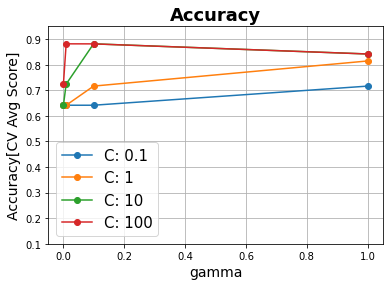

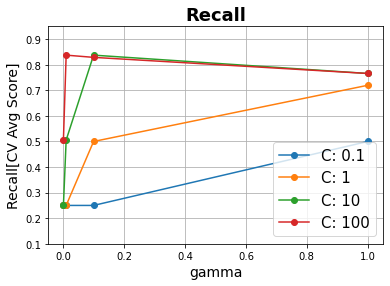

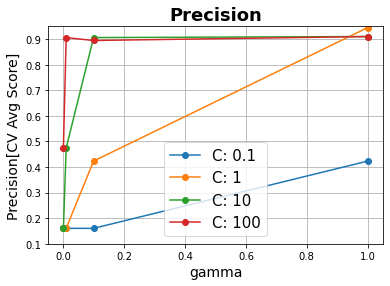

In [11]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, titre):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.set_ylim([0.1,0.95])
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title(titre, fontsize=18, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=14)
    ax.set_ylabel(titre+'[CV Avg Score]', fontsize=14)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
# Calling Method 
from pylab import rcParams
# rcParams['figure.figsize'] = 10, 5
plot_grid_search(grid_search_acc.cv_results_, params['classifier__gamma'], params['classifier__C'], 'gamma', 'C',  'Accuracy')
plot_grid_search(grid_search_rec.cv_results_, params['classifier__gamma'], params['classifier__C'], 'gamma', 'C', 'Recall')
plot_grid_search(grid_search_prec_avg.cv_results_, params['classifier__gamma'], params['classifier__C'], 'gamma', 'C', 'Precision')

In [11]:
## return index for dataframe
def return_index_list(param1, param2):
    list=[]
    for p1 in param1:
        for p2 in param2:
            list.append('['+str(p1)+', '+str(p2)+']')
    return list
index= return_index_list(params['classifier__C'], params['classifier__gamma'])

In [12]:
df= pd.DataFrame({  'Accuracy': grid_search_acc.cv_results_['mean_test_score'],
                    'Precision(Avg)': grid_search_prec_avg.cv_results_['mean_test_score'],
                    'Recall(Avg)': grid_search_rec.cv_results_['mean_test_score'],
                     'std_cross_validation': grid_search_acc.cv_results_['std_test_score']},
                 index=index)
## to excel
writer = pd.ExcelWriter('SVM.xlsx')
df.to_excel(writer, 'SVM')
writer.save()
writer.close()

In [13]:
df

,Accuracy,Precision(Avg),Recall(Avg),std_cross_validation
"[0.1, 1]",0.716462,0.423404,0.500000,0.016092
"[0.1, 0.1]",0.641692,0.160431,0.250000,0.010735
"[0.1, 0.01]",0.641692,0.160431,0.250000,0.010735
"[0.1, 0.001]",0.641692,0.160431,0.250000,0.010735
"[1, 1]",0.814769,0.945356,0.719722,0.025992
"[1, 0.1]",0.716462,0.423404,0.500000,0.016092
"[1, 0.01]",0.641692,0.160431,0.250000,0.010735
"[1, 0.001]",0.641692,0.160431,0.250000,0.010735
"[10, 1]",0.842000,0.910220,0.765789,0.047797
"[10, 0.1]",0.881692,0.906126,0.837481,0.058963


Accuracy: 0.91
Detail:
              precision    recall  f1-score   support

   formation       0.91      0.94      0.92        63
   scolarité       0.83      0.80      0.82        25
       sport       1.00      1.00      1.00        14
   événement       1.00      0.86      0.92         7

    accuracy                           0.91       109
   macro avg       0.94      0.90      0.92       109
weighted avg       0.91      0.91      0.91       109



(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'formation'),
  Text(0, 1.5, 'scolarité'),
  Text(0, 2.5, 'sport'),
  Text(0, 3.5, 'événement')])

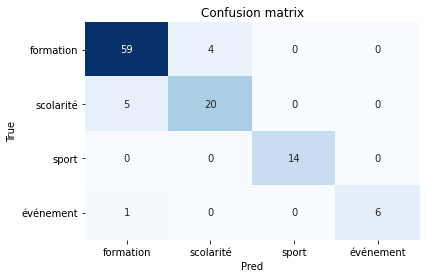

In [11]:
#evaluation
predicted = grid_search_acc.best_estimator_.predict(X_test)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test, predicted)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)